In [3]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
import os
import iris
import numpy as np
import seaborn as sns
import xarray as xr
from GridcellDataset import GridcellDataset
from pathos.multiprocessing import Pool
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

%matplotlib inline

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

In [14]:
def plot_xr(xr, label=None, vmin=None, vmax=None):
    plt.close('all')
    fig = plt.figure(figsize=(18,1))

    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)

    im = ax1.pcolormesh(xr['target'], vmin=vmin, vmax=vmax)
    ax2.pcolormesh(xr['preds'], vmin=vmin, vmax=vmax)
    ax3.pcolormesh(xr['stratiform_rainfall_amount'], vmin=vmin, vmax=vmax)
    
    ax1.set_title('target')
    ax1.set_ylabel(label)
    ax2.set_title('Random Forest (%s x %s)' %(label, label))
    ax3.set_title('Bilinear Interpolation (%s x %s)' %(label, label))

    fig.subplots_adjust(right=0.82)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax);

In [5]:
def plot(df, label=None, vmin=None, vmax=None):
    plt.close('all')
    fig = plt.figure(figsize=(18,1))

    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)

    im = ax1.pcolormesh(df['target'].unstack().values, vmin=vmin, vmax=vmax)
    ax2.pcolormesh(df['preds'].unstack().values, vmin=vmin, vmax=vmax)
    ax3.pcolormesh(df['stratiform_rainfall_amount'].unstack().values, vmin=vmin, vmax=vmax)
    
    ax1.set_title('target')
    ax1.set_ylabel(label)
    ax2.set_title('model')
    ax3.set_title('baseline')

    fig.subplots_adjust(right=0.82)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax);

In [6]:
def plot_means(df, label=None, vmin=None, vmax=None):
    means = df.groupby([pd.cut(df['lat'], np.arange(2, 3, 0.02)), 
                        pd.cut(df['lon'], np.arange(-5.1, 3.3, 0.02))]).mean()
    plot(means, label, vmin, vmax)

In [7]:
coord_system = iris.coord_systems.RotatedGeogCS(37.5, 177.5, 
                                                ellipsoid=iris.coord_systems.GeogCS(6371229.0)).as_cartopy_crs()

def transform(lon, lat):
    return coord_system.transform_point(lon, lat, ccrs.PlateCarree())

In [8]:
# Xt.reset_index(['grid_lat', 'grid_lon']).reset_coords(['grid_lat_', 'grid_lon_'])

In [9]:
train_vars = ['stratiform_rainfall_amount', 'stratiform_rainfall_amount_up',
              'stratiform_rainfall_amount_down', 'stratiform_rainfall_amount_left', 'stratiform_rainfall_amount_right', 
             'air_temperature', 'specific_humidity', 'surface_altitude', 'distance', 'latitude', 'longitude',
             'surface_air_pressure', 'x_wind', 'y_wind', 'face', 'slope']

In [10]:
%reset_selective -f train_dfs test_dfs models Xt yt train test preds rf rf_bool model
train_dfs = []
test_dfs = []
models = []
for i in [2,4,8]:
    train = pd.read_csv('../data/train{:d}.new.csv'.format(i))
    t = ['target', 'stratiform_rainfall_amount', 'stratiform_rainfall_amount_up',
         'stratiform_rainfall_amount_down', 'stratiform_rainfall_amount_left', 'stratiform_rainfall_amount_right'] 
    train[t] = np.log1p(train[t])
    
    X = train[train_vars]
    y = train['target']
    
    rf_bool = RandomForestRegressor(n_estimators=20, max_features='sqrt', n_jobs=1)
    rf_bool.fit(X, y > 0)
    
    rf = RandomForestRegressor(n_estimators=20, max_features='sqrt', n_jobs=1)
    rf.fit(X[y > 0], y[y > 0])
#     rf.fit(X, y)
    
#     rf_bool_high = RandomForestRegressor(n_estimators=20, max_features='sqrt', n_jobs=1)
#     rf_bool_high.fit(X, y > 1)
    
#     rf_high = RandomForestRegressor(n_estimators=20, max_features='sqrt', n_jobs=1)
#     rf_high.fit(X[y > 1], y[y > 1])
    
    class RF():
        def __init__(self, rf_bool, rf):
            self.rf_bool = rf_bool
            self.rf = rf
            
        def predict(self, X):
            b = self.rf_bool.predict(X) > 0.5
            res = np.zeros_like(b)*0.0
            res[b] = self.rf.predict(X)[b]
            return res
        
        def score(self, X, y):
            y_pred = self.predict(X)
            return sklearn.metrics.accuracy_score(y, y_pred)
        
    model = RF(rf_bool, rf)
#     model = rf
    
    test = xr.open_dataset('../data/id_test{:d}.new.nc'.format(i))
    test.update(test[t[1:]].apply(np.log1p))
    Xt = test[train_vars].to_array().data.reshape(len(train_vars), -1).T
    yt = test['target'] > 0
    preds = model.predict(Xt)
    
#     test['preds'] = (test.coords, preds.reshape(187,48,419))
    test['preds'] = (test.coords, np.expm1(preds).reshape(187,48,419))
    test['stratiform_rainfall_amount'] = np.expm1(test['stratiform_rainfall_amount'])
    
    test['lon'] = (test.coords,
                   coord_system.transform_points(ccrs.PlateCarree(), 
                                                 test['longitude'].data.flatten(), 
                                                 test['latitude'].data.flatten())[:,0].reshape(187,48,419))
    test['lat'] = (test.coords,
                   coord_system.transform_points(ccrs.PlateCarree(), 
                                                 test['longitude'].data.flatten(), 
                                                 test['latitude'].data.flatten())[:,1].reshape(187,48,419))
    
    train_dfs.append(train)
    test_dfs.append(test)
    models.append(model)

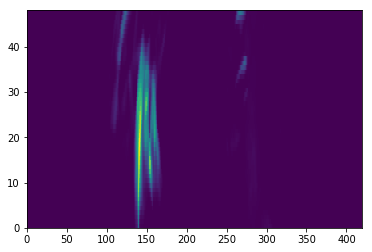

In [11]:
plt.pcolormesh(test['target'][4])

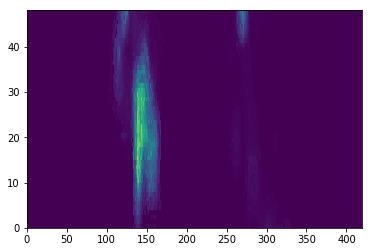

In [12]:
plt.pcolormesh(test['preds'][4])

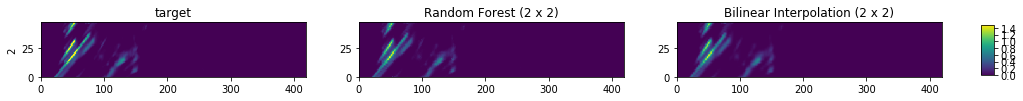

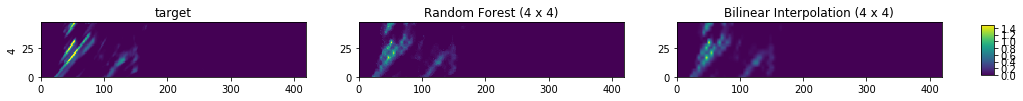

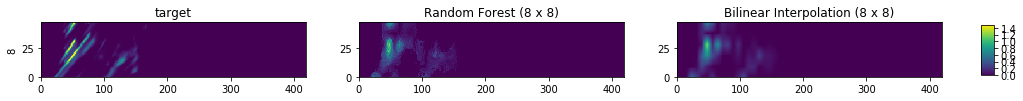

In [15]:
vmin = np.min([df[['target', 'preds', 'stratiform_rainfall_amount']].min().to_array().data for df in test_dfs])
vmax = np.max([df[['target', 'preds', 'stratiform_rainfall_amount']].max().to_array().data for df in test_dfs])

for i, test in enumerate(test_dfs):
    tstep = test.isel(fcst_id=42)
    
    plot_xr(tstep, vmin=0, vmax=1.5, label=str([2,4,8][i]))
    plt.show()

In [28]:
test['target'].values.flatten()

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

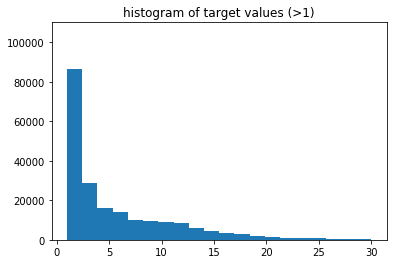

In [47]:
plt.hist(test['target'].values.flatten(),
         range=(1,30),
         bins=20);
plt.ylim(0, 110000)
plt.title('histogram of target values (>1)');

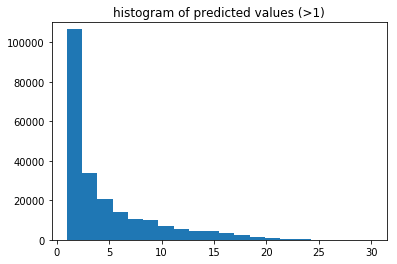

In [48]:
plt.hist(test['preds'].values.flatten(), 
         range=(1,30),
         bins=20);
plt.ylim(0, 110000)
plt.title('histogram of predicted values (>1)');

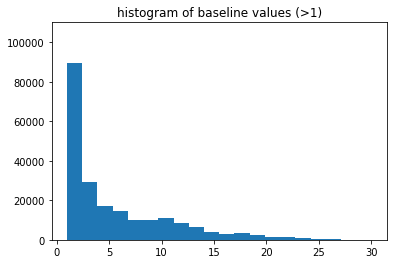

In [49]:
plt.hist(test['stratiform_rainfall_amount'].values.flatten(), 
         range=(1,30),
         bins=20);
plt.ylim(0, 110000)
plt.title('histogram of baseline values (>1)');

In [41]:
for i, m in enumerate(models):
    print(i)
    print('model error', 
          np.mean(np.square(test_dfs[i]['preds'].values.flatten() - \
                      test_dfs[i]['target'].values.flatten())))
    print('baseline error', 
          np.mean(np.square(test_dfs[i]['stratiform_rainfall_amount'].values.flatten() - \
                      test_dfs[i]['target'].values.flatten())))
    print('model - baseline', 
          np.mean(np.square(test_dfs[i]['stratiform_rainfall_amount'].values.flatten() - \
                      test_dfs[i]['preds'].values.flatten())))

0
model error 0.0592888723557
baseline error 0.0340561437252
model - baseline 0.0323945801812
1
model error 0.19822354311
baseline error 0.112497286186
model - baseline 0.0966539379658
2
model error 0.584999240662
baseline error 0.320599664218
model - baseline 0.224198169049


In [27]:
np.unique(test_dfs[0]['DOY'])

array([167, 170, 173, 197, 200, 203, 228, 231, 234])

In [28]:
cols = train_dfs[0].columns.difference(['Unnamed: 0', 'target'])

In [29]:
cols

Index(['DOY', 'Unnamed: 0.1', 'air_temperature', 'distance', 'face',
       'grid_lat', 'grid_lon', 'latitude', 'longitude', 'slope',
       'specific_humidity', 'stratiform_rainfall_amount',
       'stratiform_rainfall_amount_down', 'stratiform_rainfall_amount_left',
       'stratiform_rainfall_amount_right', 'stratiform_rainfall_amount_up',
       'surface_air_pressure', 'surface_altitude', 'x_wind', 'y_wind'],
      dtype='object')

NameError: name 'cols' is not defined

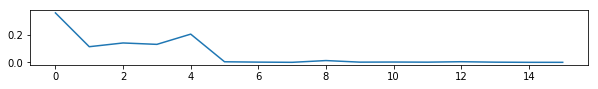

In [69]:
plt.figure(figsize=(10,1))
for i, m in enumerate(models):
    plt.plot(range(len(train_vars)), m.rf.feature_importances_, label=str([2,4,8][i]))
    plt.gca().set_xticks(range(len(cols)))
    plt.gca().set_xticklabels(train_vars, rotation='vertical')
    plt.legend()
plt.show()
plt.figure(figsize=(10,1))
for i, m in enumerate(models):
    plt.plot(range(len(train_vars)), m.rf_bool.feature_importances_, label=str([2,4,8][i]))
    plt.gca().set_xticks(range(len(cols)))
    plt.gca().set_xticklabels(train_vars, rotation='vertical')
    plt.legend()

In [31]:
test_dfs[0].to_array().data.shape

(21, 187, 48, 419)

In [32]:
(test_dfs[i]['target'] > 0).data.reshape(len(train_vars), -1).shape

(16, 235059)

In [33]:
test_dfs[i]['preds'].values.flatten()

array([ 0.02763389,  0.02763389,  0.02763389, ...,  0.        ,
        0.        ,  0.        ])

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, m in enumerate(models):
    yhat = test_dfs[i]['preds'].values.flatten()
    true = (test_dfs[i]['target'] > 0).astype(int).values.flatten()
    fpr, tpr, _ = sklearn.metrics.roc_curve(true, yhat)
    ax[i].plot(fpr, tpr, label='model')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
for j, t in enumerate(test_dfs):
    yhat = t['stratiform_rainfall_amount'].data.flatten()
    true = (t['target'] > 0).astype(int).values.flatten()
    fpr, tpr, _ = sklearn.metrics.roc_curve(true, yhat)
    ax[j].plot(fpr, tpr, label='baseline')
    ax[j].set_title([2,4,8][j])
    ax[j].set_xlabel('False Positive Rate')
    ax[j].set_ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()

In [40]:
for i, m in enumerate(models):
    print('model', 
    np.mean(np.square(test_dfs[i]['preds'].values.flatten() - \
                      test_dfs[i]['target'].values.flatten())))
    print('baseline', np.mean(np.square(test_dfs[i]['stratiform_rainfall_amount'].data.flatten() - \
                      test_dfs[i]['target'].values.flatten())))

model 0.0514684079631
baseline 0.0340561437252
model 0.198214798218
baseline 0.112497286186
model 0.524971901798
baseline 0.320599664218


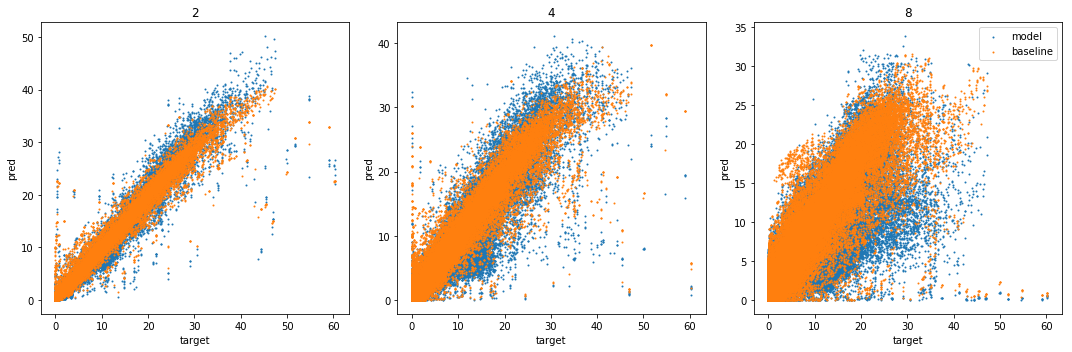

In [54]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, res in enumerate(test_dfs):
    yhat = res['preds']
    true = res['target']
    ax[i].scatter(true, yhat, s=1, label='model')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('target')
    ax[i].set_ylabel('pred')
# for i, res in enumerate(test_dfs):
    yhat = res['stratiform_rainfall_amount']
    true = res['target']
    ax[i].scatter(true, yhat, s=1, label='baseline')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('target')
    ax[i].set_ylabel('pred')
plt.legend()
plt.tight_layout()

In [74]:
test_dfs[0][train_vars]

<xarray.Dataset>
Dimensions:                           (fcst_id: 187, grid_lat: 48, grid_lon: 419)
Coordinates:
  * fcst_id                           (fcst_id) float64 1.0 2.0 3.0 4.0 5.0 ...
  * grid_lat                          (grid_lat) float64 2.03 2.05 2.07 2.09 ...
  * grid_lon                          (grid_lon) float64 -5.079 -5.059 ...
Data variables:
    stratiform_rainfall_amount        (fcst_id, grid_lat, grid_lon) float64 0.0 ...
    stratiform_rainfall_amount_up     (fcst_id, grid_lat, grid_lon) float64 0.0 ...
    stratiform_rainfall_amount_down   (fcst_id, grid_lat, grid_lon) float64 0.0 ...
    stratiform_rainfall_amount_left   (fcst_id, grid_lat, grid_lon) float64 0.0 ...
    stratiform_rainfall_amount_right  (fcst_id, grid_lat, grid_lon) float64 0.0 ...
    air_temperature                   (fcst_id, grid_lat, grid_lon) float64 287.2 ...
    specific_humidity                 (fcst_id, grid_lat, grid_lon) float64 0.008545 ...
    surface_altitude                  (fc

In [ ]:
scores = []
for i, m in enumerate(models):
    scores.append(m.score(test_dfs[i][train_vars].to_array().data.reshape(len(train_vars), -1).T,
                          test_dfs[i]['target']).data.reshape(len(train_vars), -1).T)
scores

In [10]:
def preds_vs_targets(res):
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    yhat = res['preds']
    true = res['target']
    ax[i].scatter(true, yhat, s=1, label='model')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('target')
    ax[i].set_ylabel('pred')
# for i, res in enumerate(test_dfs):
    yhat = res['stratiform_rainfall_amount']
    true = res['target']
    ax[i].scatter(true, yhat, s=1, label='baseline')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('target')
    ax[i].set_ylabel('pred')
    plt.legend()
    plt.tight_layout()

In [11]:
import xarray as xr

In [12]:
tdf = pd.read_csv('../data/id_test8.csv')
tdf = tdf[tdf['fcst_id'] > 0]

In [13]:
tx = xr.Dataset(tdf)

In [14]:
tx2 = tx.apply(lambda x: xr.DataArray(x.data.reshape((187, 48, 419)), dims=['time', 'y', 'x']))

In [15]:
proj = coord_system.transform_points(ccrs.PlateCarree(), 
                                     tx2['longitude'].data.flatten(), 
                                     tx2['latitude'].data.flatten()
                                    ).reshape(187, 48, 419, 3)[:,:,:,:2]
tx2['lon'] = (('time', 'y', 'x'), proj[:,:,:,0])
tx2['lat'] = (('time', 'y', 'x'), proj[:,:,:,1])

In [16]:
skip_vars = ['Unnamed: 0', 'Unnamed: 0.1', 'target', 'proj', 'lat', 'lon', 'fcst_id']
log_vars = ['stratiform_rainfall_amount', 'stratiform_rainfall_amount_up',
     'stratiform_rainfall_amount_down', 'stratiform_rainfall_amount_left', 'stratiform_rainfall_amount_right'] 

Xt = tx2[[k for k in tx2.data_vars.keys() if k not in skip_vars]]
for v in log_vars:
    Xt[v] = np.log1p(Xt[v])
preds = models[2].predict(Xt.to_array().data.reshape((15, -1)).T)
tx2['preds'] = (('time', 'y', 'x'), np.expm1(preds).reshape(187, 48, 419))

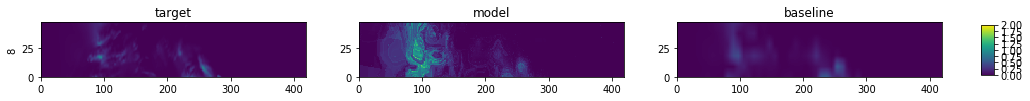

In [17]:
plot_xr(tx2.apply(lambda x: x[186]), vmin=0, vmax=2, label=str([2,4,8][i]))

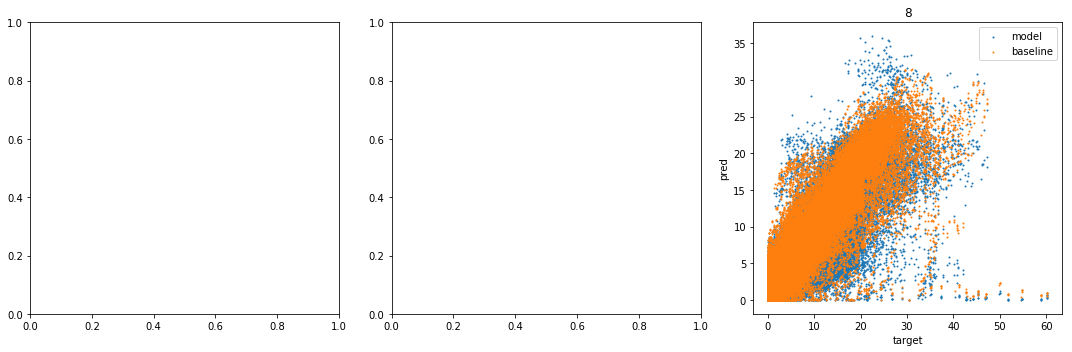

In [18]:
preds_vs_targets(tx2)

In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import holoviews as hv
from datashader.bokeh_ext import InteractiveImage
from bokeh.plotting import figure, output_notebook, show
output_notebook()

/home/ubuntu/miniconda3/lib/python3.6/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


Loading BokehJS ...

In [31]:
def create_image(x_range=x_range, y_range=y_range, w=500, h=500):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
    agg = cvs.line(raw, 'X', 'Y', agg=ds.any())
    return tf.interpolate(agg)

NameError: name 'x_range' is not defined

In [50]:
tf.shade?

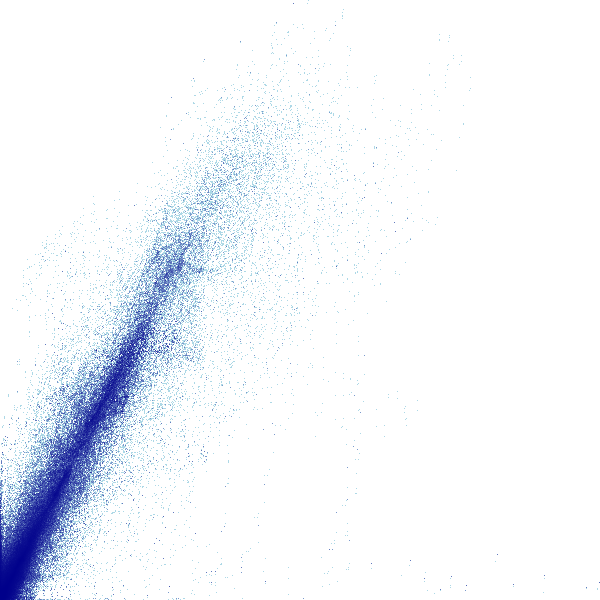

In [52]:
p = figure(
        x_range=(0, 20),
        y_range=(0, 40),
        tools='pan,wheel_zoom,box_zoom,reset', 
        plot_width=800, 
        plot_height=500,
    )
pipeline = ds.Pipeline(tx2[['target', 'preds']].to_dataframe(), ds.Point('target', 'preds'))
pipeline2 = ds.Pipeline(tx2[['target', 'stratiform_rainfall_amount']].to_dataframe(), 
                        ds.Point('target', 'stratiform_rainfall_amount'))
# p.scatter(x='target', y='preds', source=tx2[['target', 'preds']].to_dataframe())
# InteractiveImage(p, pipeline)
df = tx2[['target', 'preds', 'stratiform_rainfall_amount']].to_dataframe()
tf.shade(ds.Canvas().points(df,'target','preds'))
tf.shade(ds.Canvas().points(df,'target','stratiform_rainfall_amount'))

In [44]:
pipeline.agg

In [44]:
t = ['stratiform_rainfall_amount', 'stratiform_rainfall_amount_up',
     'stratiform_rainfall_amount_down', 'stratiform_rainfall_amount_left', 'stratiform_rainfall_amount_right'] 

test2 = pd.read_csv('../data/id_test8.csv')
test2 = test2[test2['fcst_id'] > 170]
test2['proj'] = test2.apply(lambda x: transform(x['longitude'], x['latitude']), axis=1)
test2['lon'] = test2.apply(lambda x: x['proj'][0], axis=1)
test2['lat'] = test2.apply(lambda x: x['proj'][1], axis=1)
test2[t] = np.log1p(test2[t])
Xt = test2[test2.columns.difference(['Unnamed: 0', 'Unnamed: 0.1', 'target', 'proj', 'lat', 'lon', 'fcst_id'])]
preds = models[2].predict(Xt)
test2['preds'] = np.expm1(preds)
test2['stratiform_rainfall_amount'] = np.expm1(test2['stratiform_rainfall_amount'])

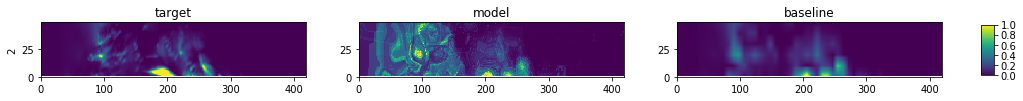

In [47]:
# plot(test2[test2['fcst_id'] == 170])
plot_means(test2[test2['fcst_id'] == 186], vmin=0, vmax=1, label=str(2))

In [113]:
# %%time
# trainset = train_dfs[0].copy()

# trainset['proj'] = trainset.apply(lambda x: transform(x['longitude'], x['latitude']), axis=1)
# trainset['lon'] = trainset.apply(lambda x: x['proj'][0], axis=1)
# trainset['lat'] = trainset.apply(lambda x: x['proj'][1], axis=1)

In [114]:
# means = trainset.groupby([pd.cut(trainset['lat'], np.arange(2, 3, 0.02)), 
#                           pd.cut(trainset['lon'], np.arange(-5.1, 3.3, 0.02))]).max()

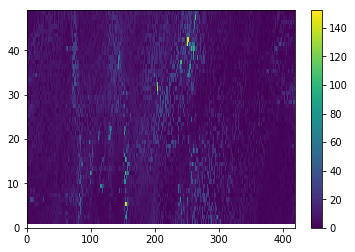

In [10]:
plt.pcolormesh(means['target'].unstack().values)
plt.colorbar()

(0, 1000)

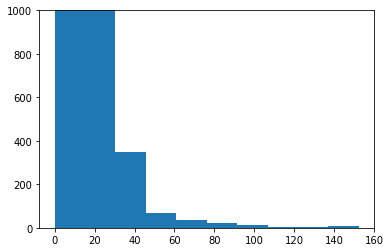

In [109]:
plt.hist(train_dfs[0]['target'])
plt.gca().set_ylim((0,1000))